## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Aprendizaje por Refuerzo


### Profesor asistente: Diego Gomez (df.gomez11@uniandes.edu.co)

En este cuaderno implementaremos un par de métodos de Aprendizaje por Refuerzo.

Utilizaremos nuestros algoritmos para intentar maximizar nuetra probabilidad de ganar en el juego de cartas Blackjack.


---


*A lo largo del ejercicio encontrará la palabra `TODO`. Esto le indica que hay una línea de código por completar.


---



Primero importeremos los paquetes necesarios. En el archivo adicional .py se encuentra el ambiente `BlackJackEnv`, que nos servirá para simlar el juego de Blackjack.

In [1]:
import numpy as np
import random

from blackjack_utils import BlackJackEnv as AmbienteBJ
from blackjack_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

semilla = 0
np.random.seed(semilla)

La clase `BlackJackEnv` tiene 2 métodos de nuestro interés:


1.   `reset`
2.   `step`  

El método `reset` inicializa el juego y se reparten las manos del jugador y del dealer. El método `step` recibe como argumento una acción y ejecuta la transición correspondiente. Las acciones posibles son 0 y 1, donde 0 corresponde a **Plantarse** y 1 corresponde a **Pedir** una nueva carta. Este método retorna 4 elementos: el estado actual, es decir, la mano del jugador y la carta del repartidor visible, el siguiente estado al tomar la acción, la recompensa obtenida y una señal que indica si ej juego terminó. La recompensa será 0 si el juego no ha terminado o hay un empate, 1 si el jugador gana y -1 si el jugador pierde.

En el área de Aprendizaje por Refuerzo es común utilizar librerías que nos proveen con múltiples ambientes. Estos ambientes usualmente tienen los mismos dos métodos que se mencionan acá.

Generemos el ambiente y juguemos un par de manos.

In [2]:
juego = AmbienteBJ(seed=semilla)
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)

Mano inicial:  [[('4', 'diamonds'), ('K', 'hearts')], ('2', 'spades')]


In [3]:
mano, siguiente_mano, recompensa, juego_terminado = juego.step(0) # Nos plantaremos
print('Nueva mano: ', siguiente_mano)
print('Recompensa: ', recompensa)
print('Juego terminado: ', juego_terminado)

Nueva mano:  [[('4', 'diamonds'), ('K', 'hearts')], [('K', 'spades'), ('2', 'spades'), ('3', 'clubs'), ('J', 'spades')]]
Recompensa:  1.0
Juego terminado:  True


In [4]:
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)

Mano inicial:  [[('9', 'hearts'), ('6', 'hearts')], ('Q', 'spades')]


In [5]:
mano, siguiente_mano, recompensa, juego_terminado = juego.step(1) # Pediremos una nueva carta
print('Nueva mano: ', siguiente_mano)
print('Recompensa: ', recompensa)
print('Juego terminado: ', juego_terminado)

Nueva mano:  [[('9', 'hearts'), ('6', 'hearts'), ('9', 'diamonds')], [('4', 'clubs'), ('Q', 'spades')]]
Recompensa:  -1.0
Juego terminado:  True


## Definición del Agente

### Ejercicio 1

Definiremos ahora la clase `Agente`. Esta clase tendrá un atributo de interés y 4 distintos métodos. El atributo corresponde la función de valor q, que es una matriz de tamaño 10x10x2x2 y donde las primeras 3 dimensiones corresponden al estado y la última a la acción. Tendrán que completar los distintos métodos, cuyas descripciones se encuentran justo antes de cada método.

In [53]:
dim_estado=(10,10,2)
dim_accion=(2,)
(dim_estado+dim_accion)

np.random.randn(dim_estado[0], dim_estado[1], dim_estado[2], dim_accion[0])

array([[[[-6.20531258e-02,  1.25916713e+00],
         [ 7.04111022e-01, -1.49567952e+00]],

        [[ 2.52636824e+00,  1.76992139e+00],
         [-1.68214223e-01,  3.77910102e-01]],

        [[ 1.32435875e+00, -1.72200793e-01],
         [ 7.30351790e-01,  1.10457847e+00]],

        [[-1.01482591e+00, -6.02331854e-01],
         [ 9.21408398e-01,  4.60814477e-01]],

        [[ 9.23796560e-01, -1.32568015e-01],
         [-2.89005211e-01, -1.99863948e+00]],

        [[-1.14600043e+00,  4.70660947e-02],
         [ 8.24557220e-01,  5.31178367e-01]],

        [[-1.28241974e-01, -2.71771566e-01],
         [ 2.17179633e-01,  7.82111811e-02]],

        [[ 1.40454551e+00,  1.46440770e-01],
         [-1.48124596e+00, -1.27255814e+00]],

        [[ 1.51875934e+00, -1.17116046e+00],
         [ 7.64497453e-01, -2.68372735e-01]],

        [[-1.69758294e-01, -1.34132783e-01],
         [ 1.22138496e+00, -1.92841829e-01]]],


       [[[-3.33192828e-02, -1.53080350e+00],
         [ 2.06690512e-01,  5.310

In [76]:
class Agente():
    def __init__(self, dim_estado=(10,10,2), dim_accion=(2,)):    
        self.funcion_q = np.random.randn(dim_estado[0], dim_estado[1], dim_estado[2], dim_accion[0]) # Funcion de valor Q
        self.n_acciones = dim_accion[0]
        
    '''
    Metodo 1:
    Este metodo transforma la mano del jugador y la carta del dealer
    a nuestra representacion de estado. 
    Argumentos:
        - estado: tupla donde el primer elemento es una lista de cartas, 
                      correspondientes a la mano del jugador, y donde el segundo 
                      elemento es la carta visible del dealer
    Salida:
        - estado transformado: tupla de 3 elementos (s_0, s_1, s_2), donde:
                  s_0:  indical el puntaje del jugador. Es un numero de 0 a 9, que 
                        corresponde a una suma de 12 a 21, en el mismo orden.
                  s_1:  indica la mano del dealer. Es un numero de 0 a 9, que corresponde
                        al valor de la carta del dealer entre 1 y 10, en el mismo orden.
                  s_2:  indica si el as es utilizable. Es un número entre 0 y 1, que
                        corresponde a si el As se puede o no utilizar como 11.                
    '''
        
    def transformar_estado(self, estado):
        suma_mano, puntaje_dealer, as_utilizable = state2code(estado)
        puntaje = suma_mano + 10*as_utilizable      
        if puntaje < 12:
            s_0 = s_1 = s_2 = None
        else:      
            s_0 = int(puntaje-12)        
            s_1 = int(puntaje_dealer-1)  
            s_2 = int(as_utilizable)
        estado_transformado = (s_0, s_1, s_2)   
        return estado_transformado
    
    '''
    Metodo 2:
    Este metodo genera una accion para sumas entre 12 y 21, siguiendo una politica
    epsilon-suave.
    Argumentos: 
      - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
      - epsilon:  valor entre 0 y 1, que corresponde al factor de exploracion
    Salidas: 
      - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
        
    '''
        
    def generar_accion_con_politica_epsilon_suave(self, estado_transformado, epsilon):
        s_0, s_1, s_2 = estado_transformado
        valores_q = self.funcion_q[s_0, s_1, s_2, :]
        if np.random.rand() > epsilon:
            accion_new = valores_q.argmax()
            if isinstance(accion_new, np.int64):
                accion = accion_new
            else:
                accion = random.choice(accion_new)
        else:
            accion = np.random.randint(0, high = self.n_acciones)
    
        return accion
    
    '''
    Metodo 3:
    Este metodo selecciona una accion para cualquier estado.
    Argumentos: 
      - estado:   tupla donde el primer elemento es una lista de cartas, 
                correspondientes a la mano del jugador, y donde el segundo 
                elemento es la carta visible del dealer
      - epsilon:  valor real positivo entre 0 y 1, que corresponde al factor de 
                exploracion
    Salidas: 
      - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
    '''
    
    def seleccionar_accion(self, estado, epsilon):
        estado_transformado = self.transformar_estado(estado)
        suma_menor_12 = estado_transformado[0] is not None
        if suma_menor_12:
            accion = self.generar_accion_con_politica_epsilon_suave(estado_transformado, epsilon)
        else:
            accion = 1
            
        return accion, estado_transformado

  
    '''
    Metodo 4:
    Este metodo actualiza los valores de la funcion q para una pareja (estado-accion),
    adicionandole una cantidad específica 
    Argumentos: 
      - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
      - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
      - cambio:   valor real que determina que tanto cambia la funcion q
      - alpha:    valor real positivo entre 0 y 1, que corresponde a la tasa de aprendizaje
    '''
    
    def actualizar_funcion_q(self, estado_transformado, accion, cambio, alpha):
        indice_pareja_estado_accion = estado_transformado + (accion,)
        self.funcion_q[indice_pareja_estado_accion] += alpha * cambio

Creemos a un agente y generemos una acción, para observar su comportamiento.

In [77]:
mano_inicial = juego.reset()
agente = Agente()
accion, estado_transformado = agente.seleccionar_accion(mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Estado: ', estado_transformado)
print('Accion tomada: '+str(accion))

Mano:  [[('4', 'hearts'), ('10', 'clubs')], ('Q', 'diamonds')]
Estado:  (2, 9, 0)
Accion tomada: 0


## Método de Monte Carlo

### Ejercicio 2.1
Definiremos un método para que el agente interactue con el ambiente por un instante de tiempo.

In [78]:
def dar_paso(juego, agente, estado, epsilon):
    # El agente selecciona una accion
    accion, estado_transformado = agente.seleccionar_accion(estado, epsilon)

    # El agente actua en el ambiente y recibe la informacion del nuevo estado,
    # la recompensa y la señal de juego terminado
    _, siguiente_estado, recompensa, juego_terminado = juego.step(accion)
    # Se crea una lista con la informacion del paso dado
    paso = [estado_transformado, accion, recompensa, juego_terminado]
          
    return paso, siguiente_estado.copy(), juego_terminado 

Daremos un paso, para probar el método que acabamos de definir.

In [79]:
mano_inicial = juego.reset()
paso, siguiente_mano, juego_terminado = dar_paso(juego, agente, mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Siguiente mano: ', siguiente_mano)
print('Juego terminado: ', juego_terminado)

Mano:  [[('6', 'hearts'), ('8', 'clubs')], ('3', 'diamonds')]
Siguiente mano:  [[('6', 'hearts'), ('8', 'clubs')], [('Q', 'clubs'), ('3', 'diamonds'), ('K', 'hearts')]]
Juego terminado:  True


### Ejercicio 2.2
Definiremos un método para que el agente juegue un juego completo y retorne una trayectoria correspondiente a este juego.

In [80]:
def generar_trayectoria(juego, agente, epsilon):
    juego_terminado = False    
    trayectoria = []
    estado = juego.reset()

    # Ciclo que genera una trayectoria. En este caso, corresponde a un juego 
    # completo de Blackjack. 
    while not juego_terminado:   
        # Se da un paso
        paso, siguiente_estado, juego_terminado = dar_paso(juego, agente, estado, epsilon)

        # Se agrega el paso a la trayectoria
        trayectoria.append(paso)    

        # Se actualiza la información del estado  
        estado = siguiente_estado.copy()

    return trayectoria  

Juguemos un juego completo a partir del metodo que acabamos de definir.

In [81]:
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Trayectoria:")
print(trayectoria)

Trayectoria:
[[(None, None, None), 1, 0.0, False], [(4, 5, 0), 0, 1.0, True]]


### Ejercicio 2.3
Definiremos un método para que el agente actualice su función q para el último paso de la trayectoria que no ha sido incluido.

In [84]:
def actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha, beta):
    # Se extrae el ultimo paso de la trayectoria que no ha sido incluido
    estado, accion, recompensa, juego_terminado = paso

    # Se actualiza el retorno como la suma de la recompensa mas el acumulado futuro
    retorno = recompensa + beta*retorno

    # Se actualiza la funcion q del agente si la suma es mayor a 12
    suma_mayor_12 = estado[0] is not None
    if suma_mayor_12:
        indice_estado_accion = estado + (accion,) 
        cambio_funcion_q = retorno - agente.funcion_q[indice_estado_accion]       
        agente.actualizar_funcion_q(estado, accion, cambio_funcion_q, alpha)
    
    return retorno

Veamos cómo cambia la función q cuando utilizamos el método.

In [88]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = 0.0
paso = trayectoria[-1]
print("Retorno (antes de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
retorno = actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha=0.1, beta=1.0)
print("Retorno (despues de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Retorno (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (antes de la actualizacion):  3.01350802996151
Retorno (despues de la actualizacion):  1.0
Valor absoluto máximo en la función q (despues de la actualizacion):  3.01350802996151


Podemos ver que inicialmente la función q está completamente llena de valores 0, mientras que después de la actualización no.

### Ejercicio 2.4
Definiremos un método para que el agente actualice su función q a partir de una trayectoria

In [89]:
def actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta):
    # Inicializamos el retorno
    retorno = 0

    # Recorremos la trayectoria desde el final hasta el comienzo para estimar el
    # retorno para cada pareja estado-accion
    for indice_ultimo_paso in range(len(trayectoria)-1,-1,-1):
      # Obtenemos un paso de la trayectoria
      ultimo_paso = trayectoria[indice_ultimo_paso]

      # Actalizamos el retorno para el paso y el valor q correspondiente
      retorno = actualizar_retorno_y_funcion_q_con_paso(agente, ultimo_paso, retorno, alpha, beta)

Repetimos el procedimiento del Ejercicio 2.3, pero ahora para una trayectoria completa. 

In [90]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha=0.1, beta=1.0)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Valor absoluto máximo en la función q (antes de la actualizacion):  3.1789924930291016
Valor absoluto máximo en la función q (despues de la actualizacion):  3.1789924930291016


### Ejercicio 2.5
Habiendo definido los métodos para generar trayectorias y actualizar la función q a partir de estas, ya podemos definir nuestro método de entrenamiento de Monte Carlo.

In [92]:
def entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios, 
                    imprimir=False, imprimir_cada_ep=5000):  
    for episodio in range(0, n_episodios):
        # Generamos una trayectoria
        trayectoria = generar_trayectoria(juego, agente, epsilon)
    
        # Actualizamos la funcion q
        actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta)
      
        if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
            print('Episodio: ' + str(episodio+1))

## Bloque de entrenamiento

Antes de probar nuestro método de Monte Carlo, vamos a definir una función que nos permitirá evaluar el desempeño del agente y de esta manera podremos saber si nuestro método lo mejora.

### Ejercicio 3.1
Primero, definamos un método que calcule el retorno de una trayectoria.

In [93]:
def calcular_retorno_trayectoria(trayectoria, beta):
    # Inicializamos el valor del retorno
    retorno = 0.0

    # Iteramos, paso por paso, y vamos sumando la recompensa de cada paso,
    # teniendo en cuenta el factor de descuento
    for t, paso in enumerate(trayectoria):
        # Obtenemos la recompensa
        recompensa = paso[2]

        # Actualizamos el retorno
        retorno += (beta ** t) * recompensa
        
    return retorno

Probemos que el método funcione en una trayectoria. 

In [94]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = calcular_retorno_trayectoria(trayectoria, beta=1.0)
print("Trayectoria: ", trayectoria)
print("Retorno: ", retorno)

Trayectoria:  [[(3, 9, 0), 0, -1.0, True]]
Retorno:  -1.0


### Ejercicio 3.2
Ahora sí definamos el método que evalua el desempeño del agente, calculando el retorno promedio en una cantidad especificada de episodios, así como su desviación estándar. 

In [95]:
def evaluar_agente(juego, agente, n_episodios, epsilon, beta,
                   imprimir=False, ciclo=0):
    retornos = []
    for episodio in range(0, n_episodios):
        # Generamos una trayectoria
        trayectoria = generar_trayectoria(juego, agente, epsilon)

        # Calculamos el retorno
        retorno = calcular_retorno_trayectoria(trayectoria, beta)

        # Añadimos el retorno a una lista de retornos
        retornos.append(retorno)
        
    # Calculamos el retorno promedio y su desviacion
    retornos = np.array(retornos)
    retorno_promedio = retornos.mean()
    desviacion_retorno = retornos.std()

    # Imprimimos el retorno si es necesario
    if imprimir:
        print(('Ciclo: ' + str(ciclo) + ', Retorno esperado: {:.3f}'.format(
        retorno_promedio) + u"\u00B1" + '{:.3f}'.format(desviacion_retorno)))
  
    return retorno_promedio, desviacion_retorno

Una vez contamos con la forma de evaluar al agente, podemos observar si nuestro algoritmo de Monte Carlo tiene un efecto positivo o no.

In [96]:
agente = Agente()
retorno_antes = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
entrenar_agente_MonteCarlo(juego, agente, alpha=0.001, beta=1.0, epsilon=1.0, n_episodios=100000)
retorno_despues = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
print("Retorno antes de entrenar: ", retorno_antes)
print("Retorno despues de entrenar: ", retorno_despues)

Retorno antes de entrenar:  (-0.3838, 0.8977179735306631)
Retorno despues de entrenar:  (-0.3864, 0.8961557007574075)


Dependiendo de la semilla, puede que el retorno después del entrenamiento sea más bajo. Esto es común en aprendizaje por refuerzo, cuando la variación es bastante alta. Sin embargo, una vez se utiliza la cantidad suficiente de episodios, lograremos ver el progreso del agente.

### Ejercicio 3.3
Nuestro último método consistirá en un bloque de entrenamiento en el que se alterna el aprendizaje del agente y su evaluación. La salida del método es una lista con la evolución del desempeño del agente.

In [100]:
def entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                    n_ciclos, n_episodios_ent, n_episodios_eval):
    
    # Se crean listas de desempeño
    retornos_media = []
    retornos_desviacion = []

    # Se ejecuta ciclo de entrenamiento y evaluacion una cantidad n_ciclos de veces
    for ciclo in range(0, n_ciclos):
        # Se entrena al agente
        entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios_ent)

        # Se evalua al agente
        G_promedio, G_desviacion = evaluar_agente(juego, agente, n_episodios_eval, epsilon, beta,
                                                  imprimir=(ciclo % imprimir_cada) == 0, ciclo=ciclo+1)

        # Guardamos el desempeño del agente
        retornos_media.append(G_promedio)
        retornos_desviacion.append(G_desviacion)

        epsilon = max(min_epsilon, epsilon * decaimiento_epsilon)

    return retornos_media, retornos_desviacion

## Entrenamiento y gráficas

Definamos los hiperparametros necesarios y ejecutemos nuestro bloque de entramiento.

In [101]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon = 1.0
min_epsilon = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [102]:
retornos_MonteCarlo = entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.383±0.896
Ciclo: 21, Retorno esperado: -0.223±0.940
Ciclo: 41, Retorno esperado: -0.130±0.953
Ciclo: 61, Retorno esperado: -0.088±0.953
Ciclo: 81, Retorno esperado: -0.072±0.951
Ciclo: 101, Retorno esperado: -0.071±0.951
Ciclo: 121, Retorno esperado: -0.078±0.953
Ciclo: 141, Retorno esperado: -0.081±0.952
Ciclo: 161, Retorno esperado: -0.070±0.953
Ciclo: 181, Retorno esperado: -0.081±0.951


In [103]:
# # Este bloque sirve para guardar y cargar el agente
# import pickle

# Para guardar
# pickle.dump(agente, open('agente_MC.pt', 'wb'))

# Para cargar
# agente = pickle.load(open('agente_MC.pt', 'rb'))

Ahora grafiquemos la curva de aprendizaje para determinar si sí hubo aprendizaje y si la cantidad de episodios fue suficiente.

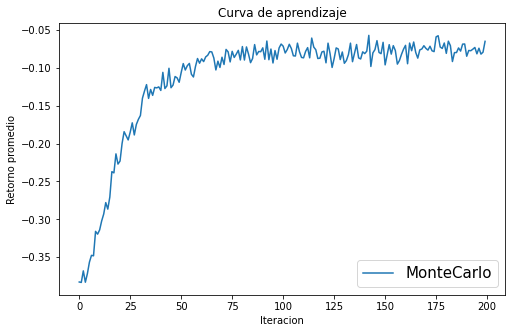

In [104]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo[0]), label='MonteCarlo')
plt.title('Curva de aprendizaje')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.legend(fontsize=15)
plt.show()
plt.close()

Por último, grafiquemos la política óptima.

In [105]:
politica_optima = agente.funcion_q.argmax(3)
politica_optima_df_dic = {}
for i in range(0,2):
    politica_optima_df_dic[str(i)] = pd.DataFrame(data=politica_optima[:,:,i], 
                                       index=range(12,22), 
                                       columns=['A']+[str(x) for x in range(2,11)])

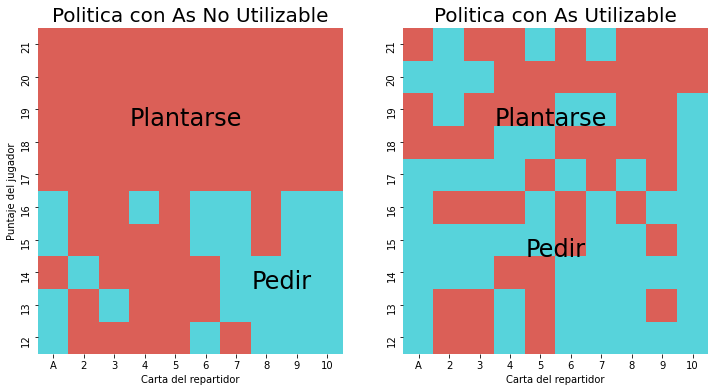

In [106]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
for i in range(0,2):
    sns_ax = sns.heatmap(politica_optima_df_dic[str(i)], ax=ax[i], 
                       cmap=sns.color_palette("hls", 2), cbar=False)
    sns_ax.invert_yaxis()
    ax[i].set_xlabel('Carta del repartidor')
    
ax[0].text(7.0, 2.0, 'Pedir', fontsize=24)
ax[0].text(3.0, 7.0, 'Plantarse', fontsize=24)
ax[1].text(4.0, 3.0, 'Pedir', fontsize=24)
ax[1].text(3.0, 7.0, 'Plantarse', fontsize=24)
ax[0].set_title('Politica con As No Utilizable', fontsize=20)
ax[1].set_title('Politica con As Utilizable', fontsize=20)
ax[0].set_ylabel('Puntaje del jugador')
plt.show()
plt.close()

# Preguntas

1.   ¿Cuál es el efecto del parámetro epsilon en la curva de aprendizaje?¿Por qué? Pruebe 3 distintos valores y compáre los resultados en una gráfica.
2.   El algoritmo que se está implementando no es exactamente igual al explicado en el video. Describa las diferencias e intente explicar por qué son necesarias. (Hint: acá se introduce un parámetro $\alpha$ que no se encuentra en el algoritmo original. ¿Qué papel está cumpliendo? La estimación de la función q supone que la política es invariante. ¿Esto se cumple?¿Por qué?) 
3.   En este caso tenemos 200 estados, ¿cree que el método puede ser tan útil para un ambiente con 2000 estados?, ¿y para uno de 2 millones?, ¿y qué pasa si el espacio de estados es continuo?¿Cómo cree que se puede atacar este problema?
4.   ¿Cree que es viable utilizar el método de programación dinámica en este problema?¿Por qué sí o por qué no?
4.   Bono: Implemente el algoritmo Q-learning o el algoritmo SARSA y haga una comparación.

1. ¿Cuál es el efecto del parámetro epsilon en la curva de aprendizaje?¿Por qué? 

Al seleccionar la siguiente acción en un episodio, se usa un valor épsilon para aumentar la exploración dentro de un episodio en lugar de seleccionar la misma acción una y otra vez. Cuando se usa el decaimiento de épsilon, a medida que se juegan más juegos, el valor de épsilon se vuelve más pequeño y el agente comienza a explotar en lugar de explorar nuevas acciones en un estado. El uso de un valor épsilon más alto resulta en una mayor exploración.

2. El algoritmo que se está implementando no es exactamente igual al explicado en el video. Describa las diferencias e intente explicar por qué son necesarias. (Hint: acá se introduce un parámetro  𝛼  que no se encuentra en el algoritmo original. ¿Qué papel está cumpliendo? La estimación de la función q supone que la política es invariante. ¿Esto se cumple?¿Por qué?)

La mayor diferencia se al introducir el parámetro $\alpha$ el cual es un valor real positivo entre 0 y 1, que corresponde a la tasa de aprendizaje.